In [17]:
import os
import json
import random
from datetime import datetime, timezone
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
url = "https://merolagani.com/handlers/TechnicalChartHandler.ashx?type=get_advanced_chart&symbol=SBL&resolution=1D&rangeStartDate=1642414253&rangeEndDate=1768820807&from=&isAdjust=1&currencyCode=NPR"
response = requests.get(url)
data = response.json()


with open("sahas.json", "w") as f:
    json.dump(data, f)

In [19]:
companies = ["/content/sahas.json"]

for symbol in companies:
    with open(f"{symbol}", 'r') as f:
        data = json.load(f)
        print(data)
    dates = [datetime.fromtimestamp(ts, tz=timezone.utc).strftime('%Y-%m-%d') for ts in data['t']]
    df=pd.DataFrame({
    "Date":dates,
    "Open":data['o'],
    "Close":data['c'],
    "High":data['h'],
    "Low":data['l'],
    "Volume":data['v']

})
    csv_filename = os.path.basename(symbol).replace('.json', '.csv')
    print(csv_filename)
    df.to_csv(csv_filename,index=False)
    print(f"{csv_filename}created")

{'t': [1642452300, 1642538700, 1642625100, 1642711500, 1642970700, 1643057100, 1643143500, 1643229900, 1643316300, 1643575500, 1643661900, 1643748300, 1643921100, 1644180300, 1644266700, 1644353100, 1644439500, 1644525900, 1644785100, 1644871500, 1644957900, 1645044300, 1645130700, 1645389900, 1645476300, 1645562700, 1645649100, 1645735500, 1645994700, 1646081100, 1646253900, 1646599500, 1646685900, 1646858700, 1646945100, 1647204300, 1647290700, 1647377100, 1647463500, 1647809100, 1647895500, 1647981900, 1648068300, 1648154700, 1648413900, 1648500300, 1648586700, 1648673100, 1648759500, 1649018700, 1649105100, 1649191500, 1649277900, 1649364300, 1649709900, 1649796300, 1649882700, 1650228300, 1650314700, 1650401100, 1650487500, 1650573900, 1650833100, 1650919500, 1651005900, 1651092300, 1651178700, 1651524300, 1651697100, 1651783500, 1652042700, 1652129100, 1652215500, 1652301900, 1652388300, 1652820300, 1652906700, 1652993100, 1653079500, 1653338700, 1653425100, 1653511500, 165359790

In [20]:
df = pd.read_csv("sahas.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
print(len(df))

928


In [21]:
# 1. Identify optimal hyperparameters
optimal_lookback = 30
optimal_layers = [64, 32]
optimal_dropout_rate = 0.1
optimal_batch_size = 64
optimal_epochs = 100
optimal_learning_rate = 0.001

print("Optimal Hyperparameters Identified:")
print(f"  Lookback: {optimal_lookback}")
print(f"  LSTM Layers: {optimal_layers}")
print(f"  Dropout Rate: {optimal_dropout_rate}")
print(f"  Batch Size: {optimal_batch_size}")
print(f"  Epochs: {optimal_epochs}")
print(f"  Learning Rate: {optimal_learning_rate}")
close = df[['Close']].values
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close)
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)


# 2. Re-create the time series sequences using the optimal lookback
X, y = create_sequences(close_scaled, optimal_lookback)

# 3. Reshape the input features X for the LSTM model
X = X.reshape(X.shape[0], X.shape[1], 1)

# 4. Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Define a new Sequential LSTM model using the identified optimal hyperparameters
final_model = Sequential([
    LSTM(optimal_layers[0], return_sequences=True, input_shape=(optimal_lookback, 1)),
    Dropout(optimal_dropout_rate),
    LSTM(optimal_layers[1]),
    Dropout(optimal_dropout_rate),
    Dense(1)
])

# 6. Compile the model using the Adam optimizer with the optimal learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=optimal_learning_rate)
final_model.compile(optimizer=optimizer, loss='mse')

final_model.summary()

# 7. Train this final model
print("\nRetraining final model with optimal hyperparameters...")
history_final = final_model.fit(
    X_train, y_train,
    epochs=optimal_epochs,
    batch_size=optimal_batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

Optimal Hyperparameters Identified:
  Lookback: 30
  LSTM Layers: [64, 32]
  Dropout Rate: 0.1
  Batch Size: 64
  Epochs: 100
  Learning Rate: 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)


Retraining final model with optimal hyperparameters...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0875 - val_loss: 0.0073
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0341
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0087
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - val_loss: 0.0078
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0072
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 0.0067
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0

In [22]:
pred_scaled = final_model.predict(X_test, verbose=0)

# Inverse-transform predictions and actual values
pred = scaler.inverse_transform(pred_scaled).flatten()
actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)

# Print results
print(f"Final Tuned Model RMSE: {rmse:.4f}")
print(f"Final Tuned Model MAE: {mae:.4f}")

Final Tuned Model RMSE: 6.2800
Final Tuned Model MAE: 4.7968


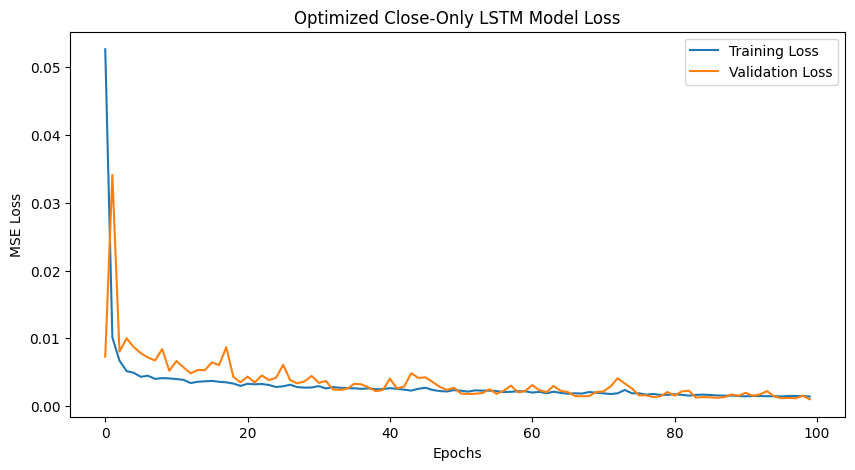

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Optimized Close-Only LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [24]:
import plotly.graph_objects as go
import numpy as np

# Create an x-axis array for the length of the actual values
x = np.arange(len(actual))

# Create a go.Figure() object
fig = go.Figure()

# Add a scatter plot for the actual prices
fig.add_trace(go.Scatter(
    x=x,
    y=actual,
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

# Add a scatter plot for the predicted prices
fig.add_trace(go.Scatter(
    x=x,
    y=pred,
    mode='lines+markers',
    name='Predicted',
    line=dict(color='red', dash='dash')
))

# Update the layout of the figure
fig.update_layout(
    title='Optimized Close-Only LSTM Model: Actual vs. Predicted Prices',
    xaxis_title='Test Sample Index',
    yaxis_title='Close Price',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

# Display the plot
fig.show()


In [25]:
final_model.save("final_model.h5")
